## IttyBittyGPT 

Author: Antony Sikorski

With lots of help and inspiration from Misha Ivanitsky and his LLM & Interpretability course, and Karpathy's NanoGPT

In this notebook we walk through:
- Building the model
- Setting up the dataset (we use TinyStories)
- and training 

This is far from the most effective available implementation, and there are a number of things that could be improved, but I have found this to be the most effective way to learn how one works.

This file has everything you need for cooking up your own little transformer and training it on a chunk of the TinyStories dataset, but doing everything in one Jupyter Notebook is not best practice. The other files in the repo are a more modular and effective way of splitting this notebook up. 

Requirements: 

In [1]:
#!pip install -r requirements.txt

In [1]:
# libraries 
import math
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from dataclasses import dataclass
import json
from collections import Counter, defaultdict
from datasets import load_dataset

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset, TensorDataset
from torch.optim.lr_scheduler import StepLR
from jaxtyping import Int, Float
import tqdm
import transformers
import transformer_lens

from muutils.misc import shorten_numerical_to_str

#imports from files
from text_dataset import TextDataset
from model import GPTConfig, GPT

c:\Python\Python_3_10\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Let's check if you have a GPU on your computer that you can run this on. That could make this process significantly faster, but you could also run out of memory (Cuda Out Of Memory error). If you don't have torch with CUDA, don't worry about this, you can just use your CPU. 

In [3]:
if(torch.cuda.is_available() == True):
    print(torch.cuda.device_count())
    print(torch.cuda.get_device_name(0))

1
NVIDIA GeForce RTX 3060 Laptop GPU


I can use my laptop GPU, which is good news! Although I believe it only has 6 GB available, and only 1.5 of them will be available...

In [4]:
# necessary auto-reload for development on local machine
%load_ext autoreload
%autoreload 2

### DataSet

Let's use the TinyStories dataset, a well known dataset that gained fame when small yet still coherent models were trained on it. The dataset is made from a bunch of GPT generated children's stories, thus it does not have much diversity in content and should theoretically be pretty easy to learn. 

We only use a small chunk of the data for the sake of making training easy on a laptop. 

In [5]:
# grabbing the whole dataset
text_data = load_dataset("roneneldan/TinyStories")

#let's only use the training data
text_data = text_data["train"]

# and let's only use the first 1000 stories 
text_data = text_data[:100]

#what does a story look like? 
print("\n Sample story (story #8):")
text_data['text'][7]

Repo card metadata block was not found. Setting CardData to empty.



 Sample story (story #8):


'Once upon a time, in a peaceful town, there lived a little boy named Tim. Tim loved to run and play outside. One day, Tim saw a race in the park. He was excited and wanted to join the race.\n\nTim went to his friend, Sarah, and said, "Let\'s start the race!" Sarah smiled and said, "Yes, let\'s go!" They lined up with the other kids and waited for the race to begin. When they heard the word "Go!", they started running as fast as they could.\n\nTim and Sarah ran with all their speed, laughing and having fun. They could feel the wind in their hair as they raced to the finish line. In the end, Tim won the race and Sarah came in second. They were both so happy and proud of themselves. They celebrated with their friends and had a great day at the park.'

Okay now let's turn our dataset into a big long list of strings, and check how long it is (we want this to be small, millions or less): 

In [6]:
text_data = "\n\n".join(text_data['text'])
len(text_data)

76060

### Training 

Here we train the model! First, we define our training loop: 

In [7]:
def train(
	model: GPT,
	text: str,
	optimizer: torch.optim.Optimizer,
	scheduler: torch.optim.lr_scheduler._LRScheduler,
	device: torch.device = ("cuda" if torch.cuda.is_available() else "cpu"),
	batch_size: int = 8,
	max_batches: int|None = None,
	print_interval: int = 100,
	epochs: int = 1,
) -> tuple[GPT, list[dict]]:
	
	# move model to device
	print(f"moving model to device: {device}")
	model.to(device)
	
	# set up data
	print(f"setting up dataset from text of length {len(text)}")
	dataset: TextDataset = TextDataset(
		text=text, 
		tokenizer=model.tokenizer, 
		n_context=model.config.n_context,
	)
	print(f"\tset up dataset with {len(dataset)} examples, example lengths: {dataset.example_lengths()}")

	print(f"setting up dataloader from {len(dataset)} examples")
	dataloader: DataLoader = DataLoader(
		dataset, 
		batch_size=batch_size, 
		shuffle=True,
	)
	print(f"\tset up dataloader with {len(dataloader)} batches of size {batch_size}")

	# set up training loop
	print("training...")
	training_records: list[dict] = list()
	model.train()

	for epoch in range(epochs):
		print(f"Epoch {epoch + 1}/{epochs}\n")
		i: int; batch: Float[torch.Tensor, "batch n_ctx"]
		for i, batch in tqdm.tqdm(
			enumerate(dataloader),
			total=len(dataloader),
			desc="Training",
		):
			# move batch to device
			batch = batch.to(device)
			
			# break if we've reached the maximum number of batches
			if max_batches is not None and i > max_batches:
				break

			# forward pass
			logits, loss = model(
				batch[:, :-1],
				targets=batch[:, 1:], # the targets are just the input, offset by one
			)

			# backward pass
			optimizer.zero_grad()
			loss.backward()
			optimizer.step()

			# record progress
			training_records.append({
				"batch": i,
				"loss": loss.item(),
			})

			if i % print_interval == 0:
				print(f"Batch {i}, Loss: {loss.item()}\n")

		scheduler.step()
    	#print(f"Updated learning rate to: {optimizer.param_groups[0]['lr']}")

	return model, training_records

Now let's configure (define params for) our own model (which will be tiny) and do some setup before we train it: 

In [8]:
# using the GPT2 tokenizer, and making sure it has the same vocab size as the model
TOKENIZER: transformers.PreTrainedTokenizer = transformers.AutoTokenizer.from_pretrained("gpt2")
print(f"{TOKENIZER.vocab_size = } \n")


# set up a config for a small model
CONFIG: GPTConfig = GPTConfig(
	d_model=8,
	d_vocab=50257,
	n_context=128,
	n_blocks=2,
	n_head=4,
)

# not the most necessary check but it felt good to do
assert(TOKENIZER.vocab_size == GPTConfig().d_vocab)

# initialize the model
MODEL: GPT = GPT(CONFIG, TOKENIZER)

#two ways of printing number of model params
print("Muutils rounded model params: ")
print(f"MODEL.n_params = {shorten_numerical_to_str(MODEL.n_params)} \n")
print("Full model params: ")
print(f"MODEL.n_params = {MODEL.n_params}")

# choice of optimizer
OPTIMIZER: torch.optim.Optimizer = torch.optim.AdamW(MODEL.parameters(), lr=1e-1)
#OPTIMIZER: torch.optim.Optimizer = torch.optim.SGD(MODEL.parameters(), lr=1e-1)
# Initialize the learning rate scheduler
SCHEDULER: StepLR = StepLR(OPTIMIZER, step_size=30, gamma=0.1)

TOKENIZER.vocab_size = 50257 

Muutils rounded model params: 
MODEL.n_params = 807K 

Full model params: 
MODEL.n_params = 806896


Let's train the model! 

In [9]:
MODEL_TRAINED, training_history = train(
	model=MODEL,
	text=text_data,
	optimizer=OPTIMIZER,
    scheduler = SCHEDULER,
	device=("cuda" if torch.cuda.is_available() else "cpu"),
	batch_size=32,
	max_batches=None,
	print_interval=100,
	epochs= 10,
)


moving model to device: cuda


Token indices sequence length is longer than the specified maximum sequence length for this model (18985 > 1024). Running this sequence through the model will result in indexing errors


setting up dataset from text of length 76060
	set up dataset with 147 examples, example lengths: Counter({129: 147})
setting up dataloader from 147 examples
	set up dataloader with 5 batches of size 32
training...
Epoch 1/10



Training:  20%|██        | 1/5 [00:10<00:40, 10.02s/it]

Batch 0, Loss: 10.986527442932129



Training: 100%|██████████| 5/5 [00:10<00:00,  2.14s/it]


Epoch 2/10



Training:  20%|██        | 1/5 [00:00<00:00,  7.01it/s]

Batch 0, Loss: 6.294719696044922



Training: 100%|██████████| 5/5 [00:00<00:00,  7.01it/s]


Epoch 3/10



Training:  20%|██        | 1/5 [00:00<00:00,  6.74it/s]

Batch 0, Loss: 6.095920085906982



Training: 100%|██████████| 5/5 [00:00<00:00,  7.24it/s]


Epoch 4/10



Training:  20%|██        | 1/5 [00:00<00:00,  6.78it/s]

Batch 0, Loss: 5.790572166442871



Training: 100%|██████████| 5/5 [00:00<00:00,  7.45it/s]


Epoch 5/10



Training:  20%|██        | 1/5 [00:00<00:00,  6.99it/s]

Batch 0, Loss: 5.612010955810547



Training: 100%|██████████| 5/5 [00:00<00:00,  7.41it/s]


Epoch 6/10



Training:  20%|██        | 1/5 [00:00<00:00,  7.38it/s]

Batch 0, Loss: 5.335344314575195



Training: 100%|██████████| 5/5 [00:00<00:00,  7.23it/s]


Epoch 7/10



Training:  20%|██        | 1/5 [00:00<00:00,  7.38it/s]

Batch 0, Loss: 4.991024971008301



Training: 100%|██████████| 5/5 [00:00<00:00,  7.07it/s]


Epoch 8/10



Training:  20%|██        | 1/5 [00:00<00:00,  7.19it/s]

Batch 0, Loss: 4.754373073577881



Training: 100%|██████████| 5/5 [00:00<00:00,  7.55it/s]


Epoch 9/10



Training:  20%|██        | 1/5 [00:00<00:00,  7.27it/s]

Batch 0, Loss: 4.460908889770508



Training: 100%|██████████| 5/5 [00:00<00:00,  7.54it/s]


Epoch 10/10



Training:  20%|██        | 1/5 [00:00<00:00,  7.14it/s]

Batch 0, Loss: 4.233498573303223



Training: 100%|██████████| 5/5 [00:00<00:00,  7.41it/s]


Now we save our trained model: 

In [10]:
torch.save(MODEL_TRAINED, "model.pt")

Some code for loading the model back in: 

In [11]:
#soon

### Analysis of Model

First, let's take a quick look at our loss: 

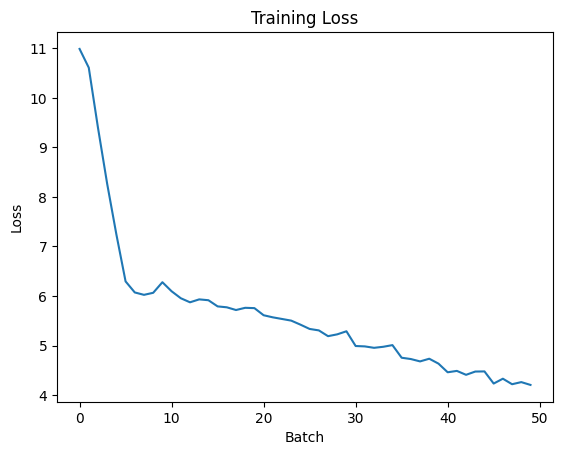

In [12]:
#plot loss over epochs
losses = [record["loss"] for record in training_history]
plt.plot(losses)
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.title("Training Loss")
plt.show()

It appears that it shakily decreased throughout the training run. Now let's test out some prompts, and see what our model gives us. 

In [13]:
print(MODEL_TRAINED.generate("Once upon a time, Tim climbed"))

 He saw The said The
 showed

 She At It She
 She



 Sue The
 The The

 The

 The  She He She fishie

 small It decided She 
 started

 found 
 Tim
â time She
 Tim
 She stepped The Then They fish

 Then The
 Theâ

 had 
 He She You wet Let
 She up She had

 â
 She
 He It

 She She
â
 The Now
 The

 seemed He Sue knew naughty
 Heâ

 He

Tom
 said






Not great, but could be much worse.. We'll come back to this and make it actually work. I'm pretty sure the model we are using is just a bit less than the smallest TinyStories model (1M), so I assume we can pull this off. 